In [10]:
import numpy as np, PIL.Image as Image, matplotlib.pyplot as plt, os, pandas as pd, datasets, torch
from utility_scripts.pose_estimation_utilities import euler_angles_to_matrix, matrix_to_euler_angles, draw_axis

In [11]:
biwi = datasets.BIWI()

In [27]:
index = 890

In [28]:
image, labels = biwi[index]

In [29]:
roll, pitch, yaw = labels['pose']

In [30]:
image = draw_axis(image.permute(1, 2, 0).numpy(), yaw = yaw, pitch = pitch, roll = roll)

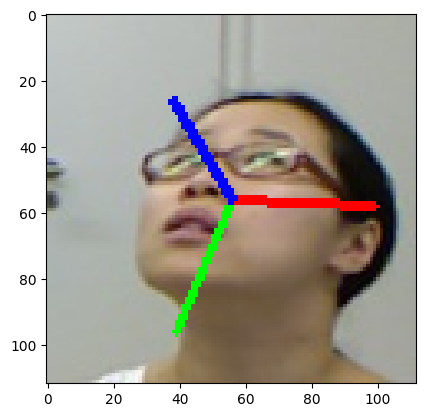

In [31]:
plt.imshow(image)